In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import warnings
import gc
import time
import argparse
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from brain_encoder_wrapper import brain_encoder_wrapper
from brain_guide_pipeline import mypipelineSAG
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
warnings.filterwarnings('ignore')
os.chdir('/engram/nklab/hossein/recurrent_models/transformer_brain_encoder/')
save_fld = '/engram/nklab/ms5724/transformer_brain_encoder/images'

### check mean roi activity across images

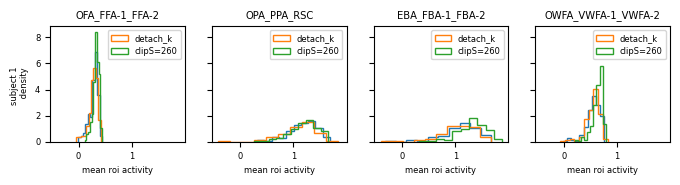

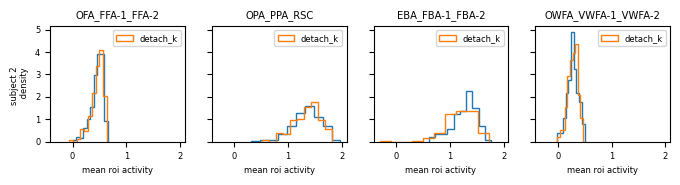

In [2]:
plt.rcParams.update({'font.size': 6})
for subj in [1, 2]:
    fig, axes = plt.subplots(1, 4, figsize=(8, 1.5), sharex=True, sharey=True)
    for i_rois, rois_list in enumerate([['OFA', 'FFA-1', 'FFA-2'], 
                                        ['OPA', 'PPA', 'RSC'], 
                                        ['EBA', 'FBA-1', 'FBA-2'], 
                                        ['OWFA', 'VWFA-1', 'VWFA-2']]):
        rois_str = '_'.join(rois_list)
        axes[i_rois].set_title(rois_str)
        for isfx, sfx in enumerate(['', 'detachk', '_clipS260']):
            try:
                model_name = f'modelSubj{subj}Layer1357Runs12345{sfx}'
                mean_act_arr = np.load(f'{save_fld}/{model_name}_{rois_str}_mean_acts.npy')
                _ = axes[i_rois].hist(mean_act_arr, histtype='step', density=True, color=f'C{isfx}', label=['', 'detach_k', 'clipS=260'][isfx])
            except:
                continue
    for ax in axes:
        ax.set_xlabel('mean roi activity')
        ax.legend()
    axes[0].set_ylabel(f'subject {subj} \n density')
    fig.savefig(f'{save_fld}/modelSubj{subj}Layer1357Runs12345_mean_acts_hist.png', bbox_inches='tight', transparent=True)

### check gradient of brain guided image generation

In [3]:
rois_list = ['OFA', 'FFA-1', 'FFA-2']
rois_str = '_'.join(rois_list)
detach_k = False
subj = 1

In [4]:
enc_output_layer = [1, 3, 5, 7]
runs = np.arange(1, 6)
model = brain_encoder_wrapper(subj=subj, enc_output_layer=enc_output_layer, runs=runs, detach_k=detach_k)
model_name = 'model'
model_name += 'Subj' + str(subj)
model_name += 'Layer' + ''.join([str(cur) for cur in enc_output_layer])
model_name += 'Runs' + ''.join([str(cur) for cur in runs])
model_name += 'detachk' if detach_k else ''
print(model_name, flush=True)

Run 1 Backbone Layer 1 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 1 Backbone Layer 3 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 1 Backbone Layer 5 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 1 Backbone Layer 7 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 2 Backbone Layer 1 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 2 Backbone Layer 3 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 2 Backbone Layer 5 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 2 Backbone Layer 7 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 3 Backbone Layer 1 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 3 Backbone Layer 3 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 3 Backbone Layer 5 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 3 Backbone Layer 7 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 4 Backbone Layer 1 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 4 Backbone Layer 3 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 4 Backbone Layer 5 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 4 Backbone Layer 7 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 5 Backbone Layer 1 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 5 Backbone Layer 3 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 5 Backbone Layer 5 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


Run 5 Backbone Layer 7 Device cuda:0


Using cache found in /home/ms5724/.cache/torch/hub/facebookresearch_dinov2_main


lh_corr_sm (4, 19004)
lh_corr_sm torch.Size([20, 19004])
modelSubj1Layer1357Runs12345


In [5]:
if model.model is not None:
    cur_model = model.model
    cur_model.lr_backbone = 1 # otherwise no gradient in brain_encoder line 68
    for name, param in cur_model.named_parameters():
        param.requires_grad = False
else:
    for cur_model in model.models:
        cur_model.lr_backbone = 1
        for name, param in cur_model.named_parameters():
            param.requires_grad = False

In [6]:
lh_challenge_rois = []
rh_challenge_rois = []
for roi in rois_list:
    roi_ind = model.lh_roi_names.index(roi)
    lh_challenge_rois.append(model.lh_challenge_rois[roi_ind]) 
    rh_challenge_rois.append(model.rh_challenge_rois[roi_ind])
lh_challenge_rois = torch.clip(torch.stack(lh_challenge_rois).sum(0), min=0, max=1).cpu().numpy()
rh_challenge_rois = torch.clip(torch.stack(rh_challenge_rois).sum(0), min=0, max=1).cpu().numpy()


def loss_function(image_input):
    outputs = model.forward(image_input)
    rois_acts = torch.mean(outputs[0] * torch.tensor(lh_challenge_rois).cuda(), axis=1) 
    rois_acts += torch.mean(outputs[1] * torch.tensor(rh_challenge_rois).cuda(), axis=1)
    return -torch.mean(rois_acts)


fld = '/engram/nklab/ms5724/transformer_brain_encoder/images'
os.makedirs(fld, exist_ok=True)
os.makedirs(f'{fld}/{model_name}', exist_ok=True)

In [7]:
repo_id = "stabilityai/stable-diffusion-2-1-base"
pipe = mypipelineSAG.from_pretrained(repo_id, torch_dtype=torch.float16, revision="fp16")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe2 = pipe.to("cuda")
pipe.brain_tweak = loss_function

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
seed = 0
gc.collect()
torch.cuda.empty_cache()
gc.collect()
g = torch.Generator(device="cuda").manual_seed(int(seed))

In [9]:
# image = pipe("", sag_scale=0.75, guidance_scale=0.0, num_inference_steps=50, generator=g, clip_guidance_scale=130.0)
# image.images[0].save(f'{fld}/{model_name}/{rois_str}_seed{seed}.png', format="PNG", compress_level=6)

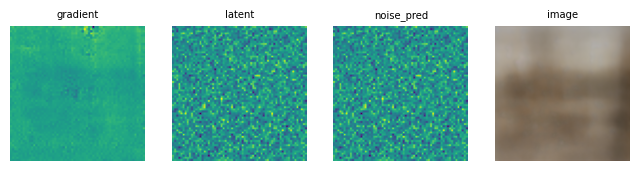

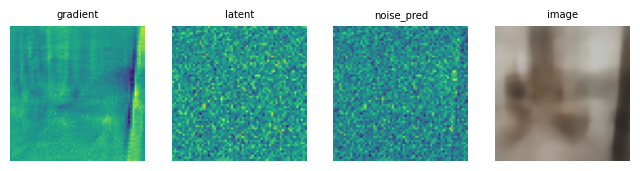

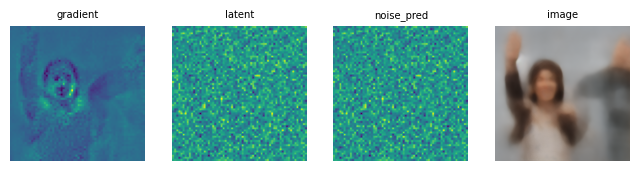

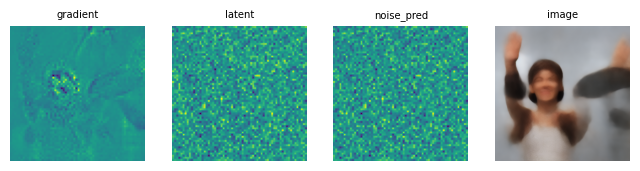

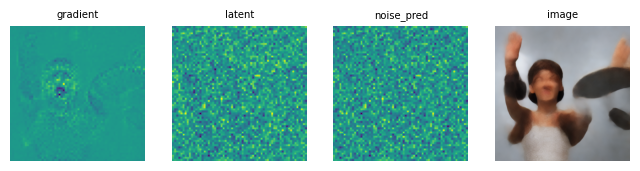

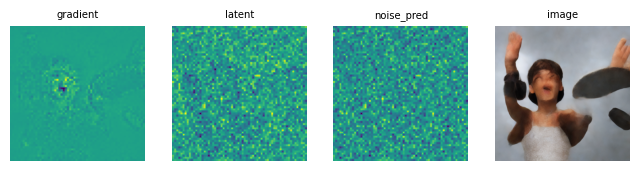

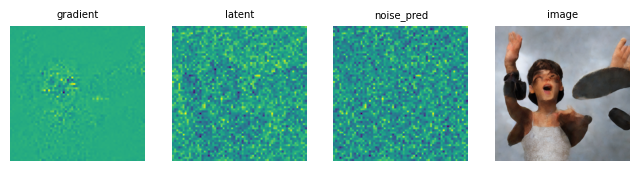

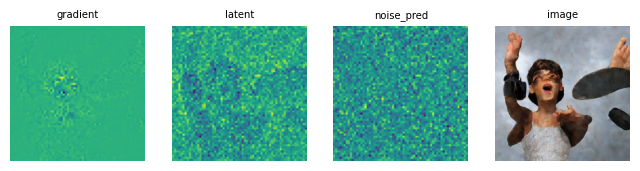

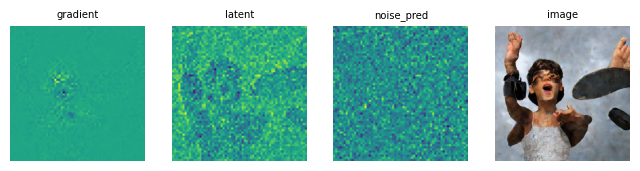

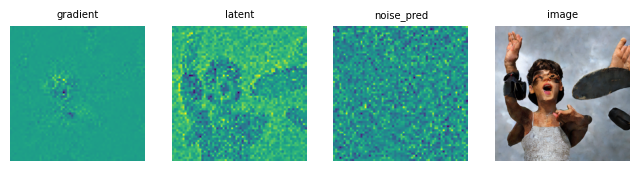

In [11]:
from brain_guide_pipeline import CrossAttnStoreProcessor
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
num_inference_steps = 50
guidance_scale = 0.0
sag_scale = 0.75
clip_guidance_scale = 130.0
generator = g
self = pipe
with torch.no_grad():
    prompt = ""
    height = self.unet.config.sample_size * self.vae_scale_factor
    width = self.unet.config.sample_size * self.vae_scale_factor
    self.check_inputs(prompt, height, width, 1, None, None, None)
    device = self._execution_device
    prompt_embeds = self._encode_prompt(prompt, device, 1, False,
                            None, prompt_embeds=None, negative_prompt_embeds=None)
    self.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = self.scheduler.timesteps
    num_channels_latents = self.unet.in_channels
    latents = self.prepare_latents(1, num_channels_latents, height, width, prompt_embeds.dtype,
                                   device, generator, None)
    extra_step_kwargs = self.prepare_extra_step_kwargs(generator, 0.0)
    store_processor = CrossAttnStoreProcessor()
    self.unet.mid_block.attentions[0].transformer_blocks[0].attn1.processor = store_processor
    if not hasattr(self, "OPENAI_CLIP_MEAN"):
        self.OPENAI_CLIP_MEAN = torch.from_numpy(np.array((0.48145466, 0.4578275, 0.40821073),
                                                          dtype=np.single)[None, :, None, None]).to(device)
        self.OPENAI_CLIP_STD = torch.from_numpy(np.array((0.26862954, 0.26130258, 0.27577711),
                                                         dtype=np.single)[None, :, None, None]).to(device)
        self.OPENAI_CLIP_MEAN.requires_grad = False
        self.OPENAI_CLIP_STD.requires_grad = False
    for i, t in enumerate(timesteps):
        latent_model_input = self.scheduler.scale_model_input(latents, t)
        noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds,
                               cross_attention_kwargs=None).sample
        pred_x0 = self.pred_x0(latents, noise_pred, t)
        cond_attn = store_processor.attention_probs
        degraded_latents = self.sag_masking(pred_x0, cond_attn, t, self.pred_epsilon(latents, noise_pred, t))
        degraded_pred = self.unet(degraded_latents, t, encoder_hidden_states=prompt_embeds).sample
        noise_pred += sag_scale * (noise_pred - degraded_pred)
        text_embeddings_for_guidance = prompt_embeds
        # noise_pred, latents = self.cond_fn(latents, t, i, text_embeddings_for_guidance, noise_pred,
        #                                    clip_guidance_scale)
        #####################################################################
        timestep = t
        text_embeddings = text_embeddings_for_guidance
        noise_pred_original = noise_pred
        with torch.enable_grad():
            latents = latents.detach().requires_grad_()
            latent_model_input = self.scheduler.scale_model_input(latents, timestep)
            noise_pred = self.unet(latent_model_input, timestep, encoder_hidden_states=text_embeddings).sample
            alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
            beta_prod_t = 1 - alpha_prod_t
            pred_original_sample = (latents - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)
            fac = torch.sqrt(beta_prod_t)
            sample = pred_original_sample * (fac) + latents * (1 - fac)
            sample = 1 / self.vae.config.scaling_factor * sample
            image = self.vae.decode(sample).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            fp32_image = image.float()
            resized_image = torch.nn.functional.interpolate(fp32_image, size=224, mode="bilinear")
            normalized_image = (resized_image - self.OPENAI_CLIP_MEAN) / self.OPENAI_CLIP_STD
            loss = self.brain_tweak(normalized_image) * clip_guidance_scale
            grads = -torch.autograd.grad(loss, latents)[0]
            latents = latents.detach()
            noise_pred = noise_pred_original - torch.sqrt(beta_prod_t) * grads
            # return noise_pred, latents
        #####################################################################
        latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample
        if np.mod(i, 5) == 0:
            fig, axes = plt.subplots(1, 4, figsize=(8, 2))
            for iax, arr in enumerate([grads, latents, noise_pred]):
                arr = arr.cpu().numpy()
                axes[iax].imshow(arr.mean((0, 1)))
            axes[-1].imshow(np.transpose(fp32_image[0].cpu().numpy(), (1, 2, 0)))
            for ax in axes:
                ax.axis('off')
            for ax, label in zip(axes, ['gradient', 'latent', 'noise_pred', 'image']):
                ax.set_title(label)
        del loss, normalized_image, resized_image, fp32_image, image

    image = self.decode_latents(latents)
    image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
    image = self.numpy_to_pil(image)
    output = StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)